# SIM Pattern Leakage Test

The purpose of this notebook is to test how much leakage occurs through the other mask holes relative to the desired peaks for different situations.

One thing to note is that the SLM effects the *electric field* but the sample responds to the *intensity* this means that during this analysis the result of the FFTs must be squared.

Remembering our previous results estimating the modulation contrast due to small variations in the two SIM beams, it doesn't take a lot to create an interference pattern. If we want to keep the spurious intereference patterns to less than 5% of the main one than we need the main peaks to have about 1,000 times more energy than the spurious ones.

In [1]:
#%%px --local
%pylab inline
#nice plotting
#import seaborn as sns
import numexpr as ne
#for minimizing the difference between the desired frequency and the calculated one
from scipy.optimize import minimize
#Need to be able to do polynomial fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
#PIL allows us to write binary images, though we need a cludge, see 'Writing Binary Files.ipynb'
from PIL import Image
import os
import zipfile

from matplotlib.patches import Circle, Wedge, Polygon

from scipy.ndimage import gaussian_filter

import seaborn as sns

from skimage.draw import circle, polygon

set_cmap('gnuplot2')

from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


In [2]:
#newest one
def pattern_gen(angle, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM
    
    Generates a sine wave and then makes it binary with a given duty cycle
    
    Parameters
    ----------
    angle : array_like
        Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step = 2
    else:
        phase_step = 1
    
    yy, xx = meshgrid(arange(sizey),arange(sizex),indexing='ij')
    
    #here's the pattern frequency
    freq = 2*pi/period
    
    phi = (phase_idx/nphases/phase_step)*(2*pi)+phase_offset
    
    #our sine goes from -1 to 1 while on frac goes from 0,1 so move onfrac into the right range
    onfrac = onfrac*2-1
    
    #given angle is the angle of the fourier spots from the 'i' vector, so pattern should be 90 degrees from this
    a=angle
    
    #do the evaluation
    toreturn = ne.evaluate("sin(freq*(cos(a)*xx+sin(a)*yy)+phi) > onfrac")
    
    return toreturn

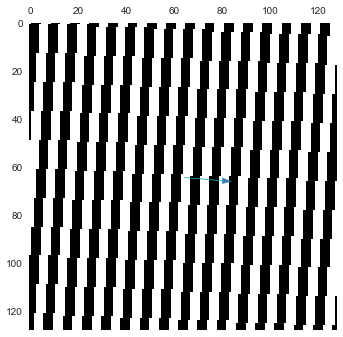

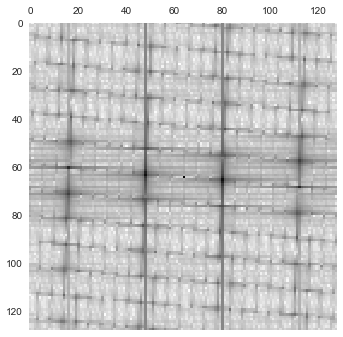

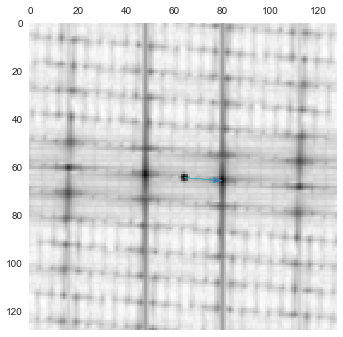

In [3]:
my_angle = deg2rad(4.76)
size=128
pat =  pattern_gen(my_angle, 8, 0.5, 0, 0, 5,size,size)
pat_fft = ifftshift(fftn(fftshift(pat)))
l = size/8
matshow(pat,cmap='Greys')
arrow(size/2,size/2,cos(my_angle)*l, sin(my_angle)*l,width=2/2048*size,ec='c')
grid('off')
matshow(abs(pat_fft),cmap='Greys',norm=LogNorm())
grid('off')
matshow(gaussian_filter(abs(pat_fft),10/2048*size),norm=LogNorm(),cmap='Greys')
arrow(size/2,size/2,cos(my_angle)*l, sin(my_angle)*l,width=2/2048*size,ec='c',length_includes_head=True)
grid('off')

In [4]:
#%%px --local
def ideal_period(wavelength, NA = 0.85):
    '''
    All units are in mm
    '''
    pixel_size = 8.2/1000 #pixel size in mm for QXGA display (4DD)
    fl = 250 #focal length of lens in mm
    fl2 = 300 #focal length of the second lens
    ftube = 200 #focal length of the tube lens, for Nikon this is 200 mm
    wl = wavelength/10**6 #wavelength of light
    mag = 1/100
    sigma = sqrt(2) * 12/pixel_size/4 #std dev of gaussian beam in units of pixels at the SLM
    pupil_diameter = 2*NA*mag*fl2    #Size of pupil image at first fourier plane
    hole_radius = 2*wl*fl/(2* pi * sigma *sqrt(2) * pixel_size) #this is the limit of hole size
    hole_radius = 0.1/2# this is more reasonable (50 um)
    period = wl * fl * (1/(pupil_diameter/2 - hole_radius))/ pixel_size #in mm
    
    return period

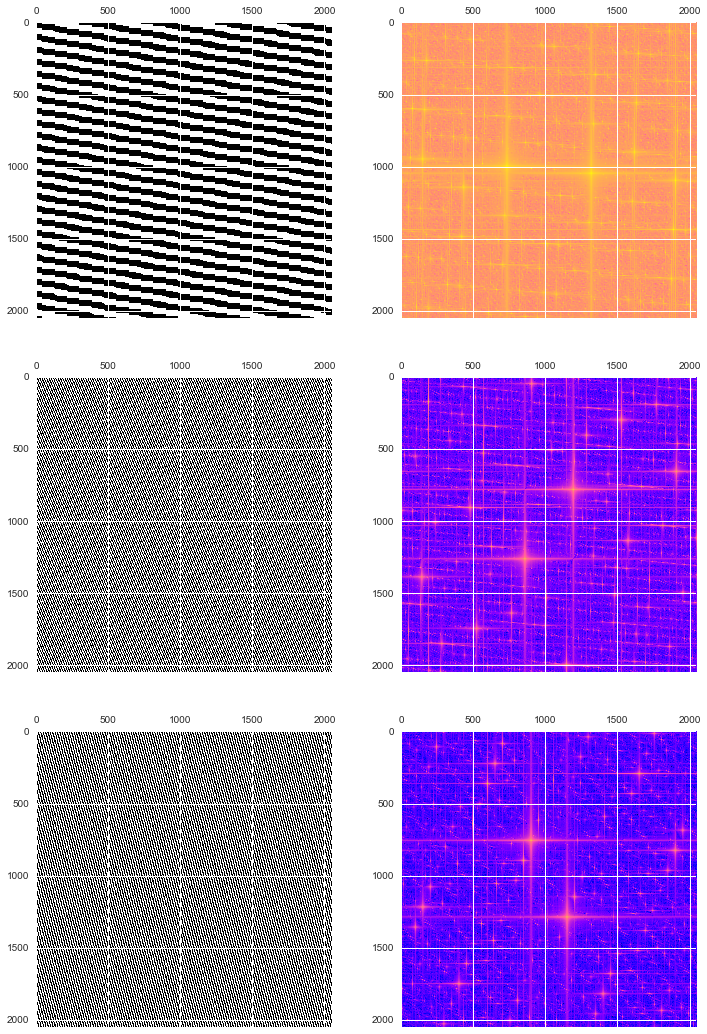

In [5]:
fig, axs = subplots(3,2, figsize=(12,18))
for i, (ax1, ax2) in enumerate(axs):
    my_angle= deg2rad(4.76-i*60)
    pat =  pattern_gen(my_angle, 7, 0.5, 0, 0, 5,2048,2048)
    pat_fft = ifftshift(fftn(fftshift(pat)))
    ax1.matshow(pat)
    ax2.matshow(abs(pat_fft),norm=LogNorm())

In [6]:
def peak_amp(angle, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    Using 2nd order polynomial fit along either axis
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = pattern_gen(angle, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = ifftshift(fftn(fftshift(my_pat)))
    
    my_pat_fft_abs = abs(my_pat_fft)
    
    dc_loc = ((np.array(my_pat_fft.shape)+1)//2)
    
    #make mask
    mask = ones_like(my_pat_fft_abs)
    mask[circle(*dc_loc,radius=10)]=0
    mask[:dc_loc[0]]=0
    
    #mask data and find next biggest peak
    masked_fft_data = mask*my_pat_fft_abs
    max_loc = unravel_index(masked_fft_data.argmax(),masked_fft_data.shape)
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)//2
    end = region_size+start

    my_pat_fft_suby = masked_fft_data[max_loc[0]+start:max_loc[0]+end,max_loc[1]]
    my_pat_fft_subx = masked_fft_data[max_loc[0],max_loc[1]+start:max_loc[1]+end]
    
    x = arange(start,end)
    
    try:
        xfit = polyfit(x, my_pat_fft_subx,2)
        yfit = polyfit(x, my_pat_fft_suby,2)
    except TypeError as e:
        print('start = {}, end = {}'.format(start,end))
        print(max_loc)
        print(my_pat_fft_subx)
        amp=nan
        x0 = nan
        y0 = nan
    else:

        xpoly = poly1d(xfit)

        x0 = -xfit[1]/(2*xfit[0])
        y0 = -yfit[1]/(2*yfit[0])
        
        amp = xpoly(0)/xpoly(x0)*yfit[2]

    precisepeak = array(max_loc)+array([x0,y0])-array(dc_loc)
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    precise_period = n/norm(precisepeak)
    
    return dict(precise_period=precise_period,pat = my_pat, pat_fft = my_pat_fft,amp = amp)

810951.300313
1001514.03236
964339.981437


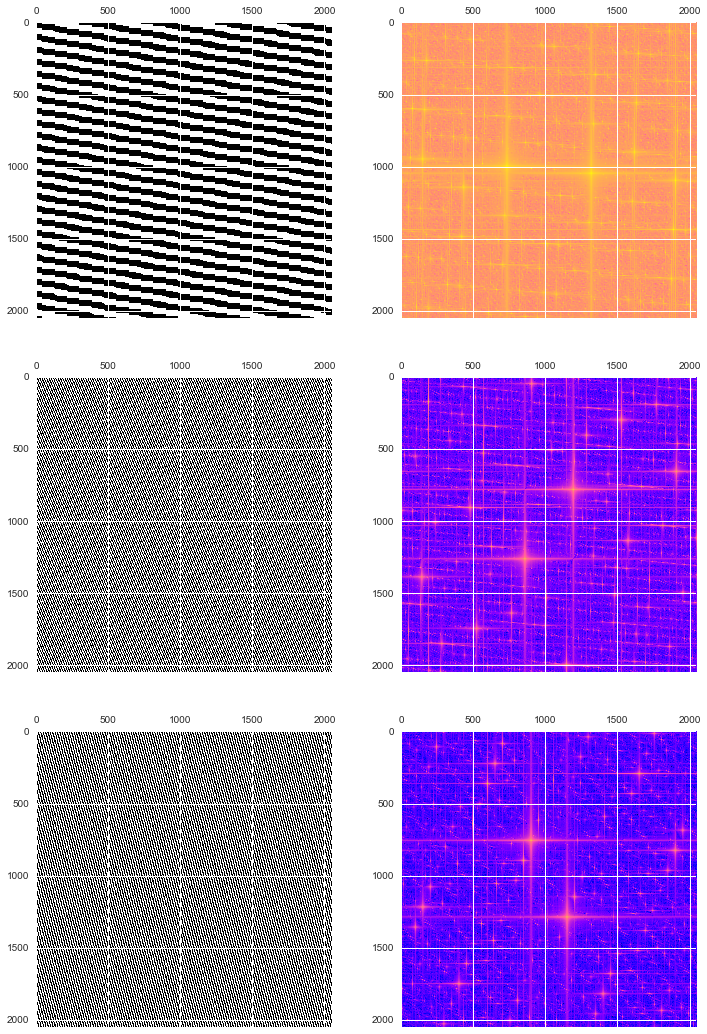

In [7]:
fig, axs = subplots(3,2, figsize=(12,18))
for i, (ax1, ax2) in enumerate(axs):
    angle =deg2rad(4.76-i*60)
    pat_dict =  peak_amp(array(angle), 7, 0.5, 0, 0, 5,2048,2048)
    ax1.matshow(pat_dict['pat'])
    ax2.matshow(abs(pat_dict['pat_fft']),norm=LogNorm())
    print(pat_dict['amp'])

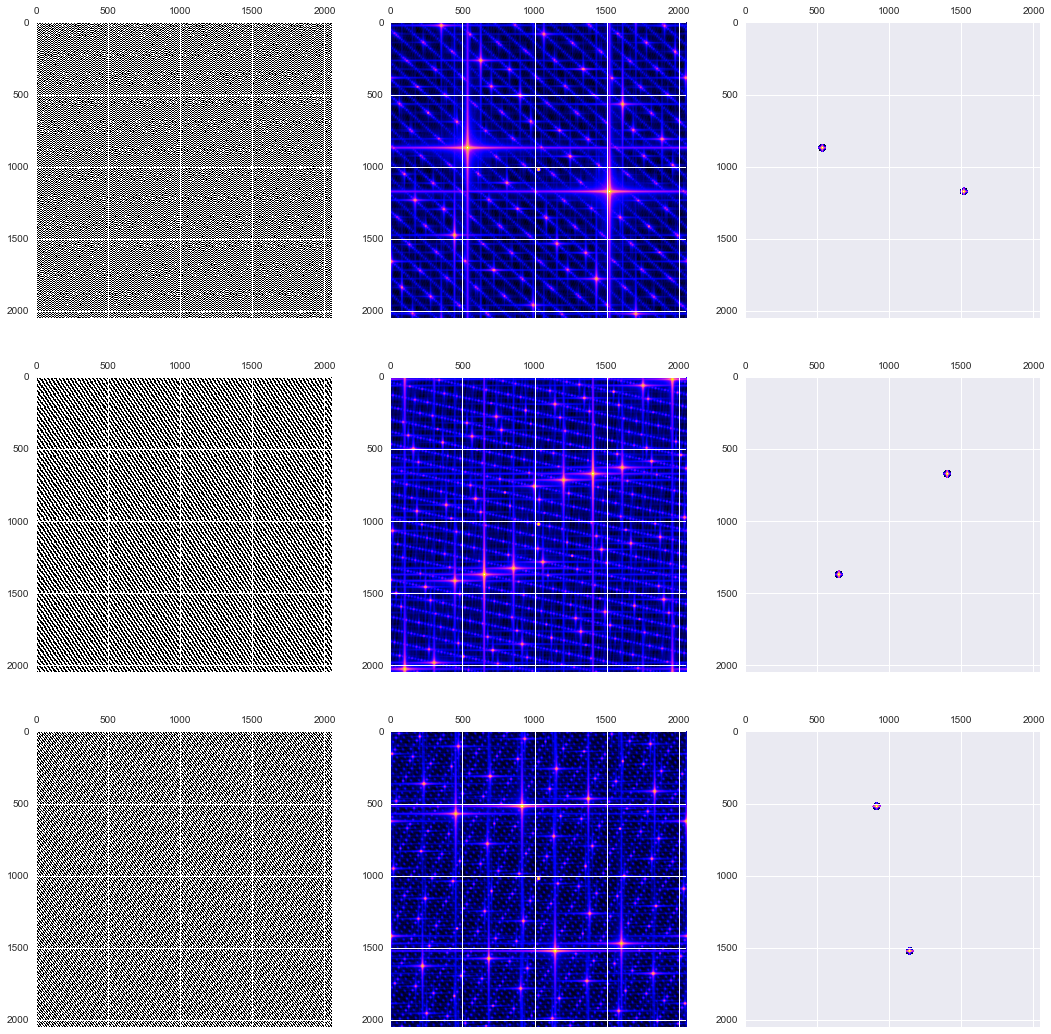

In [8]:
fig, axs = subplots(3,3, figsize=(18,18))
for i, (ax1, ax2, ax3) in enumerate(axs):
    period = 4
    a0 = deg2rad(17.1-i*60)
    pat_dict =  peak_amp(a0, period, 0.5, 0, 0, 5,2048,2048)
    ax1.matshow(pat_dict['pat'])
    blurred_fft = gaussian_filter(abs(pat_dict['pat_fft']),4)
    ax2.matshow(blurred_fft,norm=LogNorm())
    
    mask = zeros_like(blurred_fft)
    mag = 2048/period
    mask[circle(sin(a0)*mag+1024,cos(a0)*mag+1024,28)] = 1
    mask[circle(-sin(a0)*mag+1024,-cos(a0)*mag+1024,28)] = 1
    
    ax3.matshow(blurred_fft*mask,norm=LogNorm())

In [9]:
def calc_FT_radius(wl,radius = 460/2):
    pixsize = 8.2
    return radius/(wl*1e-3*250000/pixsize/2048)

In [10]:
def calc_pat_data(wl = 561, numangles=3, initangle = 17.1, rad = 220):
    my_pat_data = {}
    period = ideal_period(wl)

    if isinstance(initangle,ndarray):
        #need this check because minimize passes arrays which aren't hashable or compatible with the circle function
        initangle = float(initangle)
    
    for i in range(numangles):
        a0 = deg2rad(initangle+i*180/numangles)

        pat_dict =  peak_amp(a0, period, 0.5, 0, 0, 3,2048,2048)

        mask = zeros_like(pat_dict['pat'])

        mag = 2048/period

        radius = calc_FT_radius(wl, radius=rad)
        
        mask[circle(sin(a0)*mag+1024,cos(a0)*mag+1024,radius)] = 1
        mask[circle(-sin(a0)*mag+1024,-cos(a0)*mag+1024,radius)] = 1

        my_pat_data[initangle+i*180/numangles] = {'pat_dict' : pat_dict, 'mask' : mask}
        
    return my_pat_data

In [11]:
def add_spurious_mag(pat_data, show_plot = False, g_width=None):
    s = set(pat_data.keys())
    for k,v in sorted(pat_data.items()):

        spurious = zeros_like(v['mask'])
        for k2 in s-set([k]):
            spurious+=pat_data[k2]['mask']
        primary = v['mask']
        
        #we want fft**2 because the pattern at the SLM gives the E-field
        #but the sample responds to the intensity (this is how you get a sinusoidal pattern.)
        my_fft = abs(v['pat_dict']['pat_fft'])**2
        
        if g_width is not None:
            my_fft = gaussian_filter(my_fft,g_width)
        
    
        if show_plot:
            fig,(ax1,ax2) =subplots(1,2) 
            ax1.matshow(primary+spurious*2)
            ax2.matshow(abs(my_fft),norm=LogNorm())
            
        v['spurious'] = (my_fft*spurious).sum()
        v['primary'] = (my_fft*primary).sum()
        v['ratio'] = v['spurious']/v['primary']

In [12]:
x = linspace(0,30,501)
fom = []
for xx in x:
    my_pat = calc_pat_data(initangle=xx)
    add_spurious_mag(my_pat)
    all_primary = array([v['primary'] for v in my_pat.values()])
    fom.append(all_primary.std()/all_primary.mean())

start = -1, end = 2
(0, 0)
[]


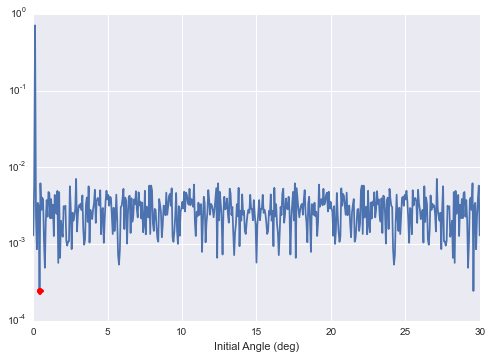

In [13]:
semilogy(x,fom)
best_fom = nanargmin(fom)
semilogy(x[best_fom],fom[best_fom],'ro')
xlabel('Initial Angle (deg)')

In [12]:
#different starting angles
for i in (4.76,10.0,17.1):
    test_pat = calc_pat_data(initangle=i)
    add_spurious_mag(test_pat,show_plot=False)
    for k,v in test_pat.items():
        print('{:.1f} has {:.3e} leakage'.format(k,v['ratio']))

64.8 has 4.195e-05 leakage
124.8 has 1.671e-05 leakage
4.8 has 1.000e-06 leakage
10.0 has 2.970e-06 leakage
130.0 has 1.410e-05 leakage
70.0 has 4.731e-06 leakage
17.1 has 1.666e-06 leakage
77.1 has 3.255e-06 leakage
137.1 has 9.341e-06 leakage


In [13]:
#different wavelengths
for i in (400,500,600,700):
    test_pat = calc_pat_data(i)
    add_spurious_mag(test_pat)
    print('Wavelength = ',i)
    for k,v in test_pat.items():
        print('{:.1f} has {:.3e} leakage'.format(k,v['ratio']))

Wavelength =  400
17.1 has 3.838e-06 leakage
77.1 has 2.576e-05 leakage
137.1 has 2.012e-04 leakage
Wavelength =  500
17.1 has 7.473e-04 leakage
77.1 has 5.765e-06 leakage
137.1 has 2.548e-06 leakage
Wavelength =  600
17.1 has 7.708e-07 leakage
77.1 has 3.294e-06 leakage
137.1 has 3.033e-06 leakage
Wavelength =  700
17.1 has 4.230e-07 leakage
77.1 has 4.505e-06 leakage
137.1 has 2.660e-06 leakage


In [14]:
#different number of holes
for i in (3,5,7,9,11):
    test_pat = calc_pat_data(numangles=i)
    add_spurious_mag(test_pat,show_plot=False)
    print('# angles = ',i)
    for k,v in sorted(test_pat.items()):
        print('{:.1f} has {:.3e} leakage'.format(k,v['ratio']))

# angles =  3
17.1 has 1.666e-06 leakage
77.1 has 3.255e-06 leakage
137.1 has 9.341e-06 leakage
# angles =  5
17.1 has 5.754e-04 leakage
53.1 has 5.708e-05 leakage
89.1 has 8.370e-04 leakage
125.1 has 1.137e-05 leakage
161.1 has 4.064e-05 leakage
# angles =  7
17.1 has 6.063e-04 leakage
42.8 has 6.222e-05 leakage
68.5 has 3.221e-04 leakage
94.2 has 2.215e-04 leakage
120.0 has 4.204e-03 leakage
145.7 has 3.411e-05 leakage
171.4 has 2.051e-02 leakage
# angles =  9
17.1 has 5.951e-04 leakage
37.1 has 5.443e-05 leakage
57.1 has 1.647e-04 leakage
77.1 has 9.914e-04 leakage
97.1 has 1.244e-04 leakage
117.1 has 1.116e-04 leakage
137.1 has 4.196e-05 leakage
157.1 has 9.672e-04 leakage
177.1 has 2.940e-04 leakage
# angles =  11
17.1 has 8.162e-05 leakage
33.5 has 4.173e-04 leakage
49.8 has 1.235e-02 leakage
66.2 has 6.646e-04 leakage
82.6 has 5.559e-04 leakage
98.9 has 1.385e-03 leakage
115.3 has 1.210e-04 leakage
131.6 has 4.821e-05 leakage
148.0 has 1.294e-04 leakage
164.4 has 8.471e-04 leaka

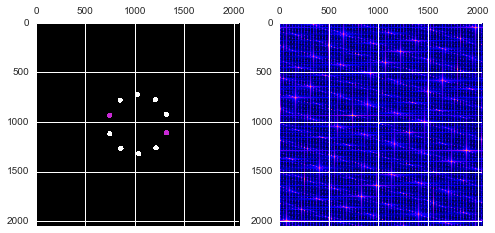

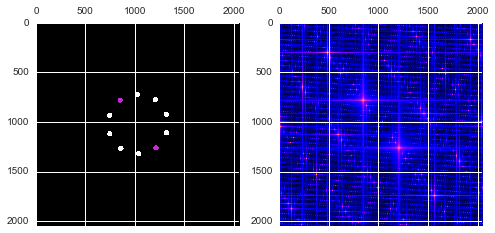

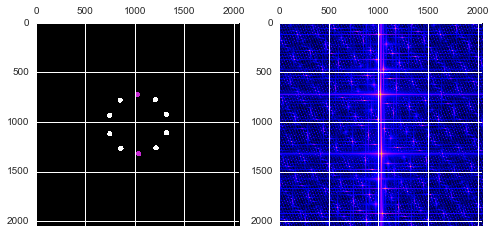

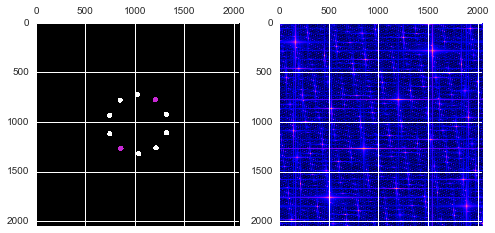

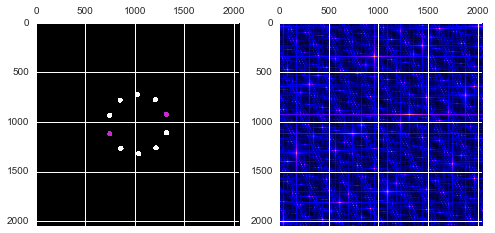

In [15]:
test_pat = calc_pat_data(numangles=5)
add_spurious_mag(test_pat,show_plot=True,g_width=1)

In [16]:
#different size of hole
for i in (100,150,200,250):
    test_pat = calc_pat_data(numangles=7,rad=i)
    add_spurious_mag(test_pat)
    print('Radius = ',i)
    for k,v in sorted(test_pat.items()):
        print('{:.1f} has {:.3e} leakage'.format(k,v['ratio']))

Radius =  100
17.1 has 3.826e-06 leakage
42.8 has 2.433e-05 leakage
68.5 has 4.146e-06 leakage
94.2 has 1.570e-04 leakage
120.0 has 1.062e-05 leakage
145.7 has 9.140e-07 leakage
171.4 has 1.149e-04 leakage
Radius =  150
17.1 has 5.492e-04 leakage
42.8 has 4.501e-05 leakage
68.5 has 1.541e-05 leakage
94.2 has 1.754e-04 leakage
120.0 has 2.751e-05 leakage
145.7 has 1.308e-05 leakage
171.4 has 2.028e-02 leakage
Radius =  200
17.1 has 6.029e-04 leakage
42.8 has 6.029e-05 leakage
68.5 has 2.165e-04 leakage
94.2 has 2.087e-04 leakage
120.0 has 1.867e-04 leakage
145.7 has 3.281e-05 leakage
171.4 has 2.049e-02 leakage
Radius =  250
17.1 has 6.095e-04 leakage
42.8 has 8.214e-05 leakage
68.5 has 3.996e-04 leakage
94.2 has 2.381e-04 leakage
120.0 has 4.496e-03 leakage
145.7 has 4.236e-05 leakage
171.4 has 2.054e-02 leakage


In [17]:
def calc_leakage(num, **kwargs):
    #different starting angles
    angles = linspace(0,30,num)
    maxes = []
    means = []
    for i in angles:
        #print('Angle = ',i)
        test_pat = calc_pat_data(initangle=i,**kwargs)
        add_spurious_mag(test_pat,show_plot=False)
        #for k,v in test_pat.items():
        #    print('{:.1f} has {:.3e} leakage'.format(k,v['spurious']))

        all_spur = array([v['ratio'] for v in test_pat.values()])
        maxes.append(nanmax(all_spur))
        means.append(nanmean(all_spur))
    
    return array(maxes), array(means)

In [24]:
def plot_leakage(maxes,means,my_slice = slice(None,None,None)):
    angles = linspace(0,30,len(maxes))
    min_mean_arg = means[my_slice].argmin()
    min_mean_arg += my_slice.start
    min_angle = angles[min_mean_arg]
    min_mean = means[min_mean_arg]
    semilogy(angles,maxes,label='Max')
    semilogy(angles,means,label = 'Mean')
    semilogy(min_angle,min_mean,'o',label = 'Min {:.3f}'.format(min_angle))
    xlabel('Initial Angle (deg)')
    ylabel('Ratio of Spurious to Desired')
    title('Amount of Leakage as a Function of Initial Angle')
    #axis('tight')
    legend(loc='best')

In [22]:
maxes_7, means_7 = calc_leakage(501,numangles = 7, rad=200)

start = -1, end = 2
(0, 0)
[]


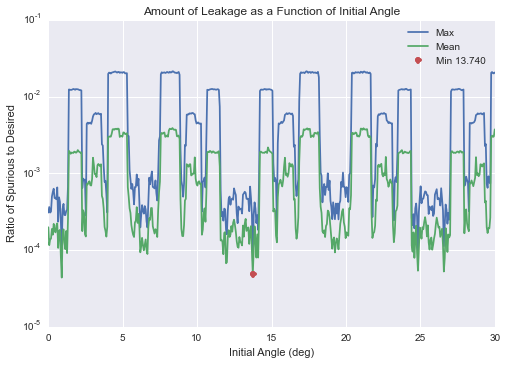

In [25]:
plot_leakage(maxes_7,means_7,my_slice=slice(100,250))
#savefig('Leakage 0-30 7 orients.pdf')

In [19]:
def opt_angle(iangle,**kwargs):
    def objf_l1(angle):
        test_pat = calc_pat_data(initangle=angle,**kwargs)
        add_spurious_mag(test_pat,show_plot=False)

        all_spur = array([v['ratio'] for v in test_pat.values()])
        return all_spur.max()
    
    return minimize(objf_l1, iangle ,method='Nelder-Mead')['x']

In [26]:
opt_angle(11.580)

start = -1, end = 2
(0, 0)
[]


array([ 11.58021204])

13.7 has 3.967e-05 leakage
39.5 has 5.203e-05 leakage
65.2 has 7.232e-05 leakage
90.9 has 2.252e-05 leakage
116.6 has 2.105e-05 leakage
142.3 has 6.156e-05 leakage
168.0 has 7.031e-05 leakage


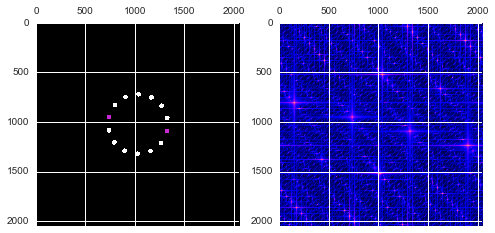

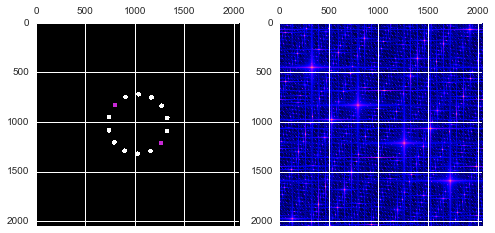

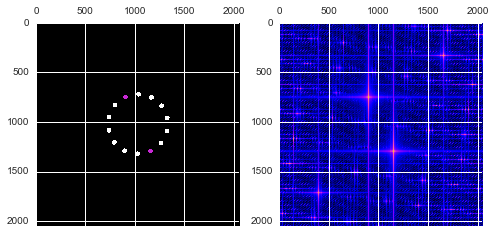

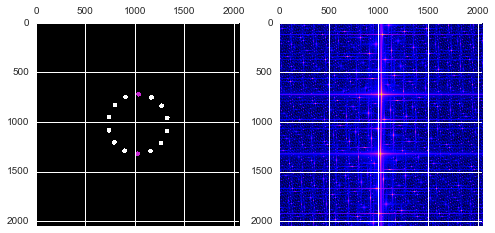

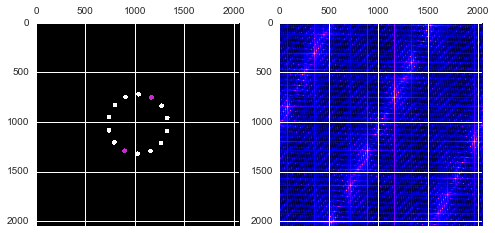

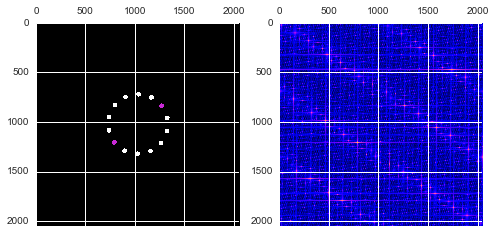

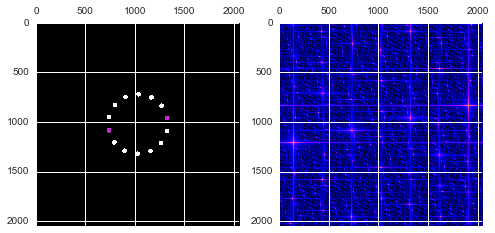

In [20]:
test_pat = calc_pat_data(initangle=13.74,numangles=7, rad = 200)
add_spurious_mag(test_pat,show_plot=True,g_width=1)
for k,v in sorted(test_pat.items()):
    print('{:.1f} has {:.3e} leakage'.format(k,v['ratio']))

64.6 has 7.179e-06 leakage
124.6 has 2.311e-06 leakage
4.6 has 2.953e-05 leakage
64.6 has 2.393e-06 leakage
124.6 has 1.458e-06 leakage
4.6 has 8.211e-06 leakage


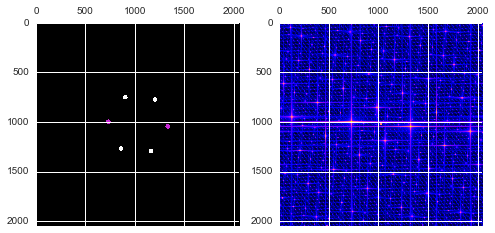

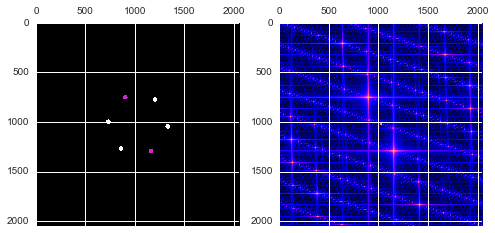

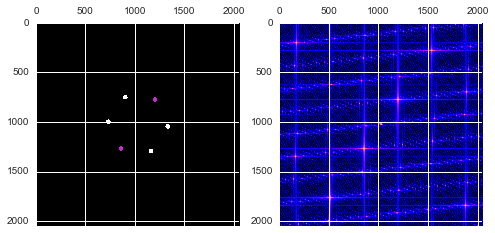

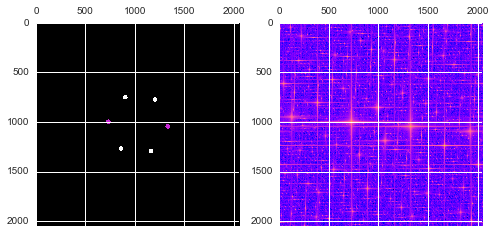

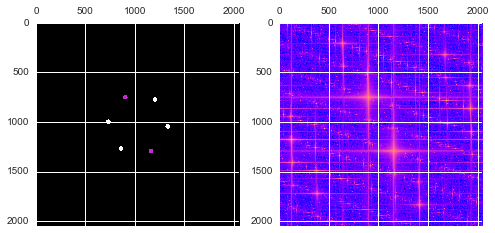

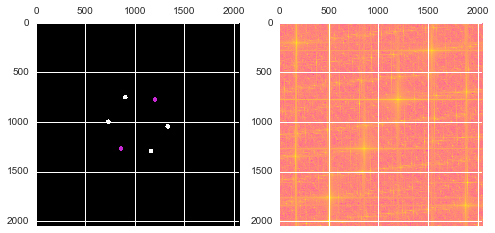

In [21]:
#with and without Gaussian Blurring.
for i in (2,None):
    test_pat = calc_pat_data(initangle=4.58,numangles=3, rad = 190)
    add_spurious_mag(test_pat,show_plot=True,g_width=i)
    for k,v in test_pat.items():
        print('{:.1f} has {:.3e} leakage'.format(k,v['ratio']))